# PC ratio notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
# from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum
from pulse_shape import find_rise_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
print('cs far')
f_name = '../data/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

cs far
152057 events


In [9]:
# convert waveform time scale to nanoseconds
wave_times = np.linspace(0,1/(250*10**6)*50000*10**9,50000)

In [10]:
# downsample data so filters can handle it
# maybe your computer is better than mine and you can remove the downsampling
cs_down = cs[::10]
print(len(cs_down))

15206


In [11]:
# Use same filter parameters as lab 1
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)
peaking_time = 100 * 4 * 10**(-9)
gap_time = peaking_time * 5  

print('Filter parameters:')
print('tau =',tau)
print('peaking time = ', peaking_time)
print('gap time = ', gap_time)

Filter parameters:
tau = 4.3869703144020734e-05
peaking time =  4.0000000000000003e-07
gap time =  2.0000000000000003e-06


In [12]:
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [13]:
filtered_cs = Cooper_filter.filter_waveform(cs_down,normalize=True)

In [14]:
# load filtered waveforms into 'spectrum'
spec = spectrum(filtered_cs,bins=2000)

<IPython.core.display.Javascript object>


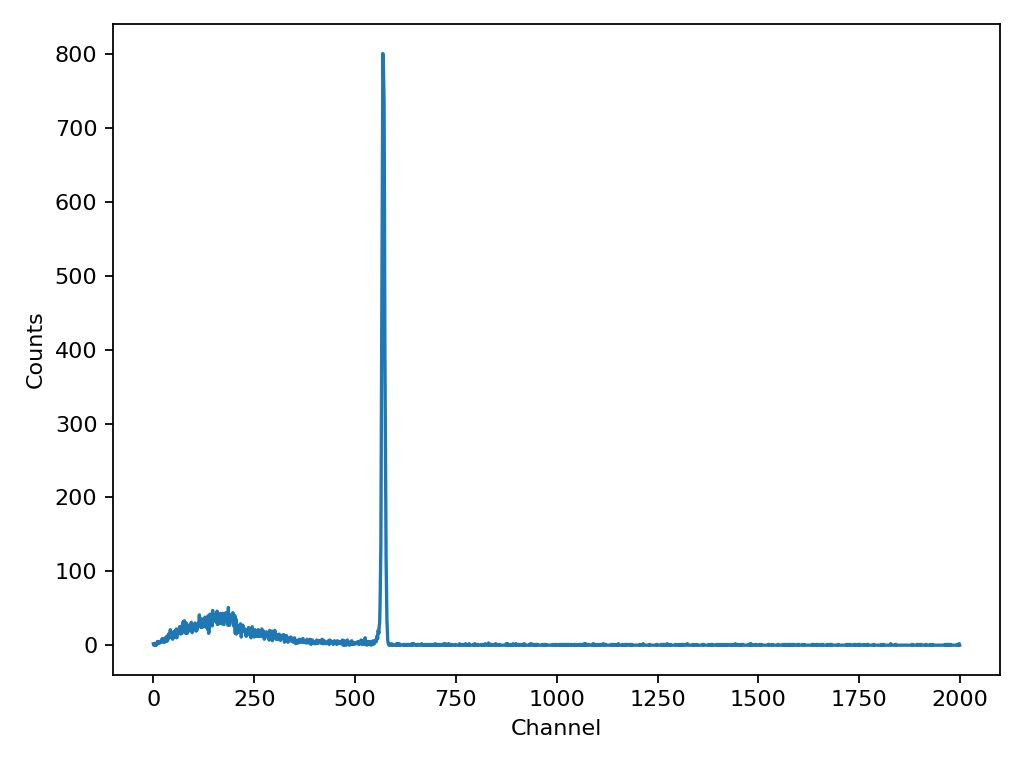

In [16]:
# spectrum histograms trapezoid into a spectrum
spec.plot_spectrum(energy=False,show_calibrated_peaks=False)

Finding Peaks


<IPython.core.display.Javascript object>


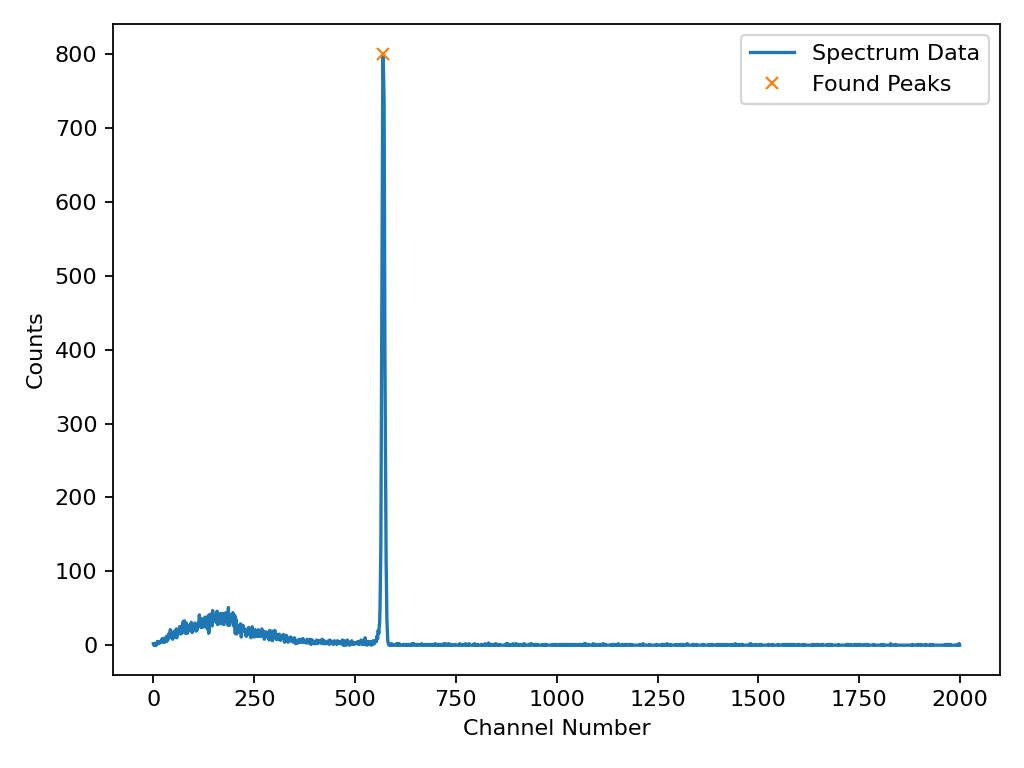

In [18]:
# find gamma peaks
spec.find_gamma_peaks(show_plot=True,prominence=50,width=[0,10])

Fitting gaussian


<IPython.core.display.Javascript object>


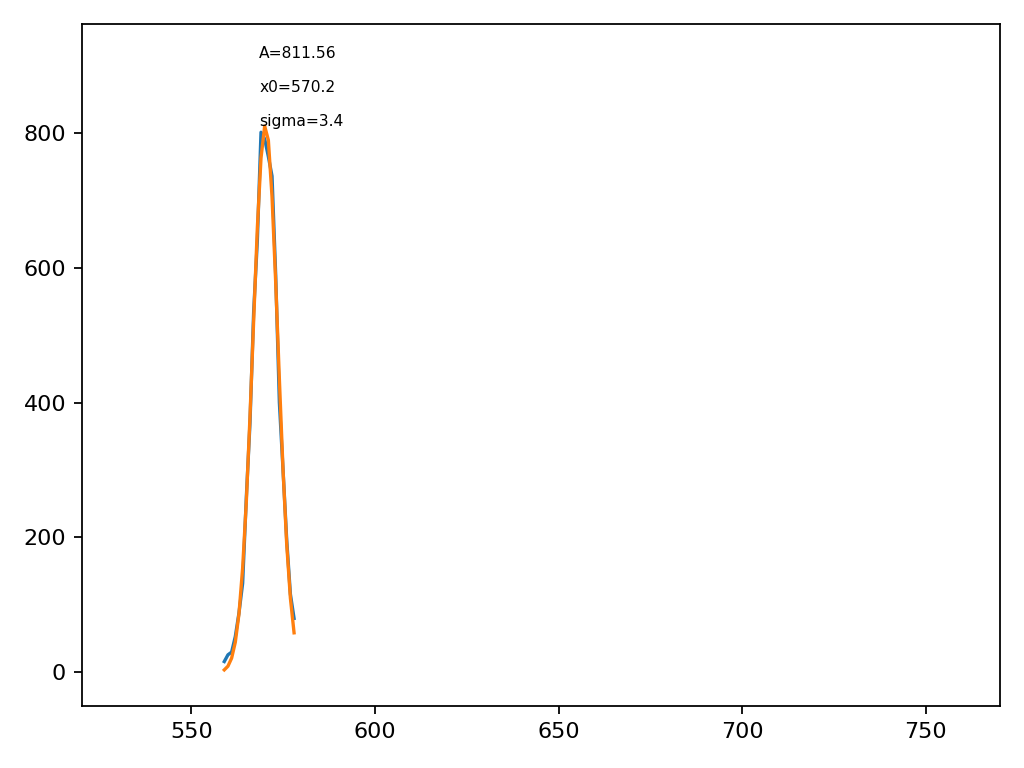

In [19]:
# perform gaussian fit to refine peak positions, find sigma, and counts in peaks
spec.fit_gaussian(show_plot=True,show_fitvalues=True)

In [20]:
# relevant gamma energies
# energies=[356.0129, 661.7,  1173.228, 1332.492]
# compton_edges = np.array([477.,963.,1118.])
compton_edges = np.array([477.])
# # k40 and tl208
# background_peaks = np.array([1460.820,1764,2614.511])
# possible_pileups = np.array([1173.228+1332.492,662*2,1173.228*2,1332.492*2])

# energies = [356.0129, 661.7,  1173.228, 1332.492, 1460.820]
energies = [661.7]

# provide energies of gamma peaks selected by peak fitting algorithm
spec.find_energy_calibration(energies=energies,alternative='greater')

Finding energy calibration


<IPython.core.display.Javascript object>


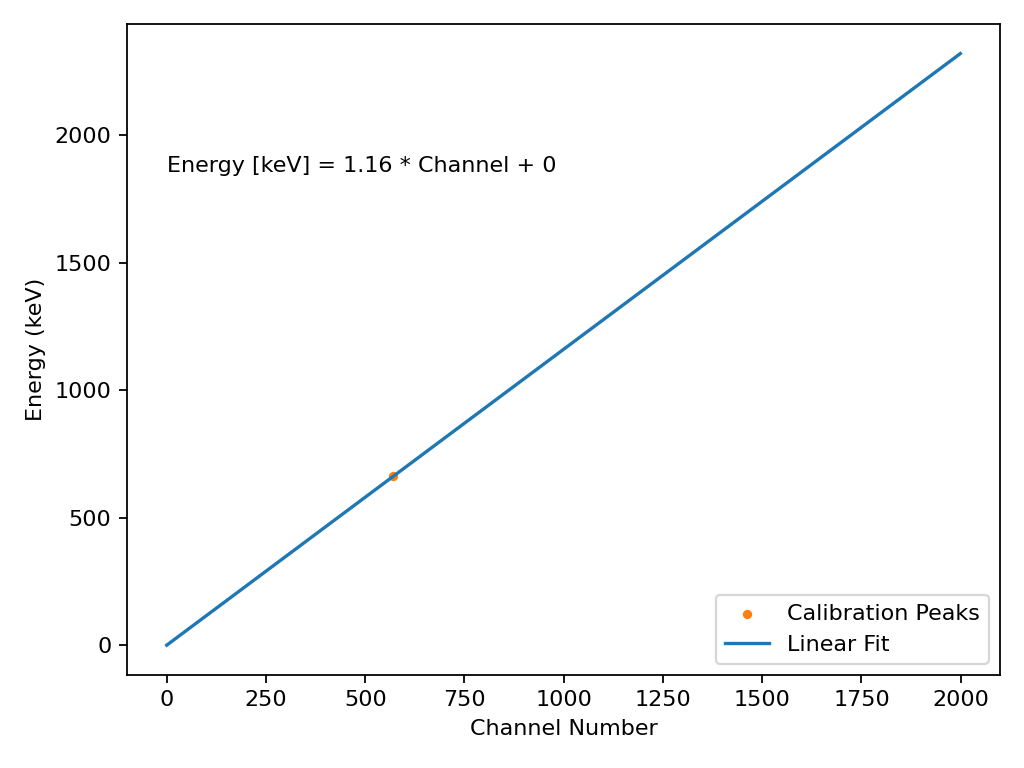

Energy [keV] = 1.16 * Channel + 0


In [22]:
# visualize energy calibration
# zoom in for error bars
spec.plot_energy_calibration(show_equation=True)

<IPython.core.display.Javascript object>


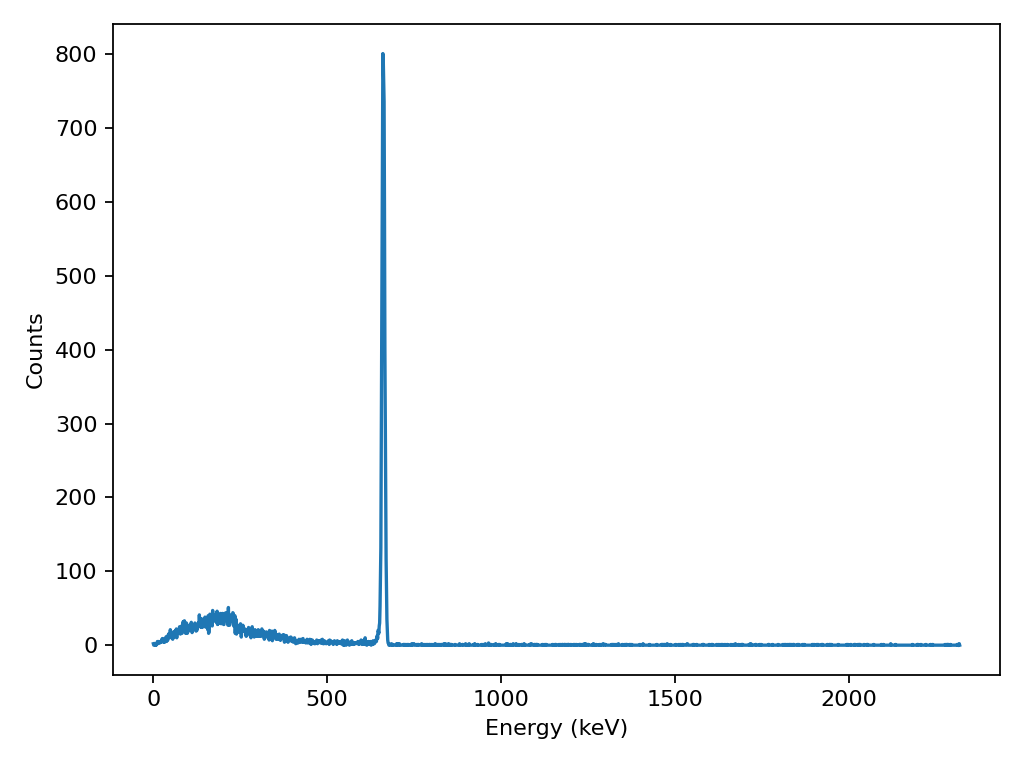

In [24]:
# see spectrum with x-axis as energy
spec.plot_spectrum(show_calibrated_peaks=False)

In [25]:
# check that expected energies are close to fit energies
fitted_energies = energies
#fitted_energies.append(background_peaks[0])

print(np.isclose(fitted_energies,spec.bin_energies[spec.peaks],atol=5))
fitted_energies - spec.bin_energies[spec.peaks]

[ True]


array([1.38934072])

<IPython.core.display.Javascript object>


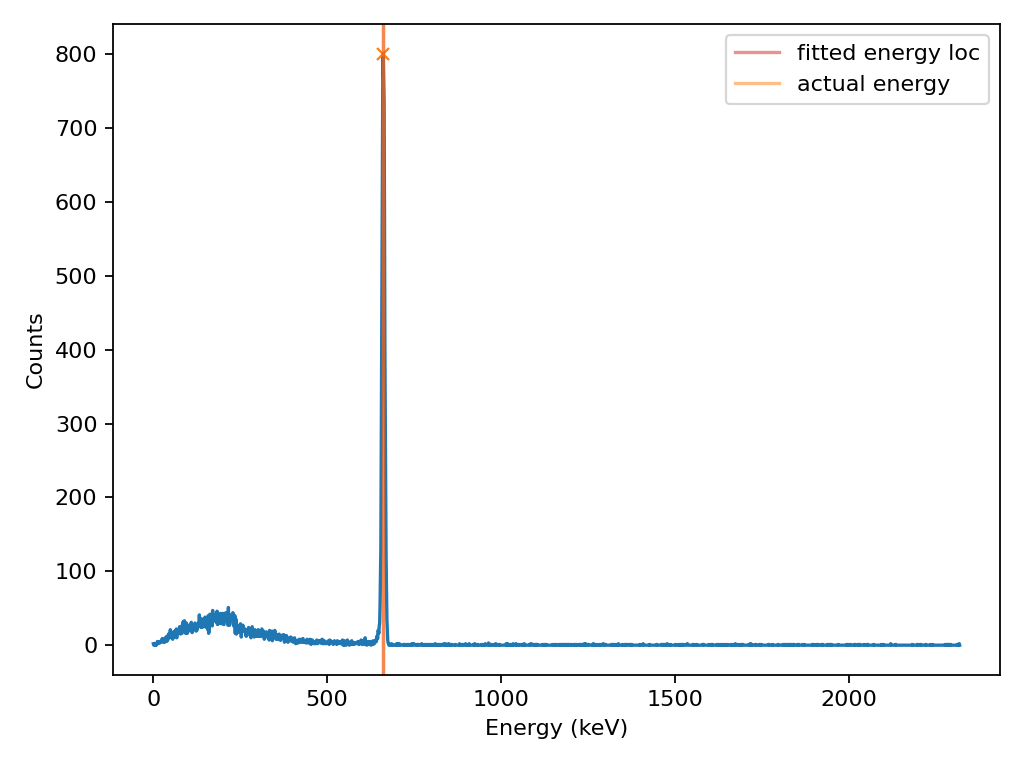

In [26]:
# see deviations from expected energy
# see spectrum with x-axis as energy
spec.plot_spectrum()
plt.axvline(spec.bin_energies[spec.peaks[0]],c='tab:red',alpha=0.5,label='fitted energy loc')
plt.axvline(fitted_energies[0],c='tab:orange',alpha=0.5,label='actual energy')
for i in range(len(spec.peaks)-1):
    plt.axvline(spec.bin_energies[spec.peaks[i+1]],c='tab:red',alpha=0.5)
    plt.axvline(fitted_energies[i+1],c='tab:orange',alpha=0.5)
plt.legend()

<IPython.core.display.Javascript object>


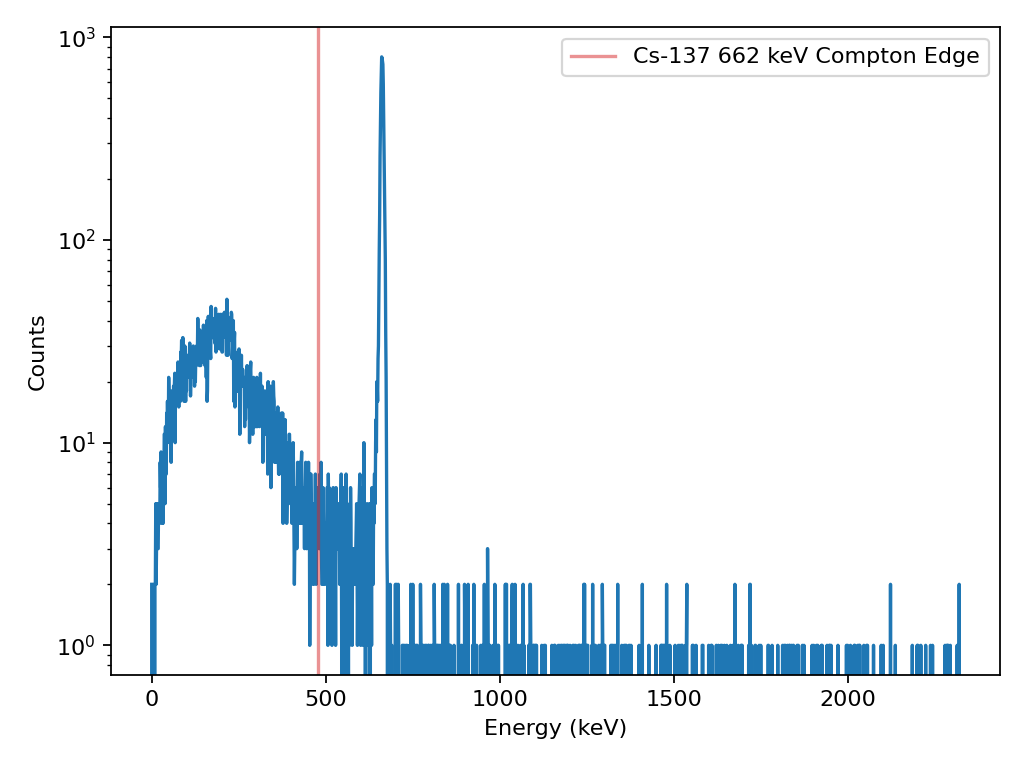

In [28]:
# highlight compton edges
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.axvline(compton_edges[0],c='tab:red',alpha=0.5,label='Cs-137 662 keV Compton Edge')
# plt.axvline(compton_edges[1],c='tab:orange',alpha=0.5,label='Co-60 1173 keV Compton Edge')
# plt.axvline(compton_edges[2],c='tab:green',alpha=0.5,label='Co-60 1332 keV Compton Edge')
plt.legend()
# plt.savefig('figs/spectrum_and_compton_edges.png')
# for i in range(len(compton_edges)):
#     plt.axvline(compton_edges[i],c='tab:red',alpha=0.5,label='Expected Compton Edges')

In [30]:
from spectrum import find_compton_edge

In [109]:
# PC ratio
photopeak_counts = spec.counts[spec.peaks]
        
# get count in typical channel of compton continuum

# find compton edge to help with searching
compton_edge = find_compton_edge(spec.energies)
compton_edge_channels = np.argwhere(np.isclose(spec.bin_energies,compton_edge,atol=1)).flatten()

compton_edge_setback = 65
compton_bin_width = 20
compton_counts = spec.counts[compton_edge_channels[0]-compton_edge_setback]
compton_counts = spec.counts[(compton_edge_channels[0]-compton_edge_setback*2):(compton_edge_channels[0]-compton_edge_setback)].mean()

pc_ratio = (photopeak_counts / compton_counts)[0]
pc_ratio

75.34732272069465

<IPython.core.display.Javascript object>


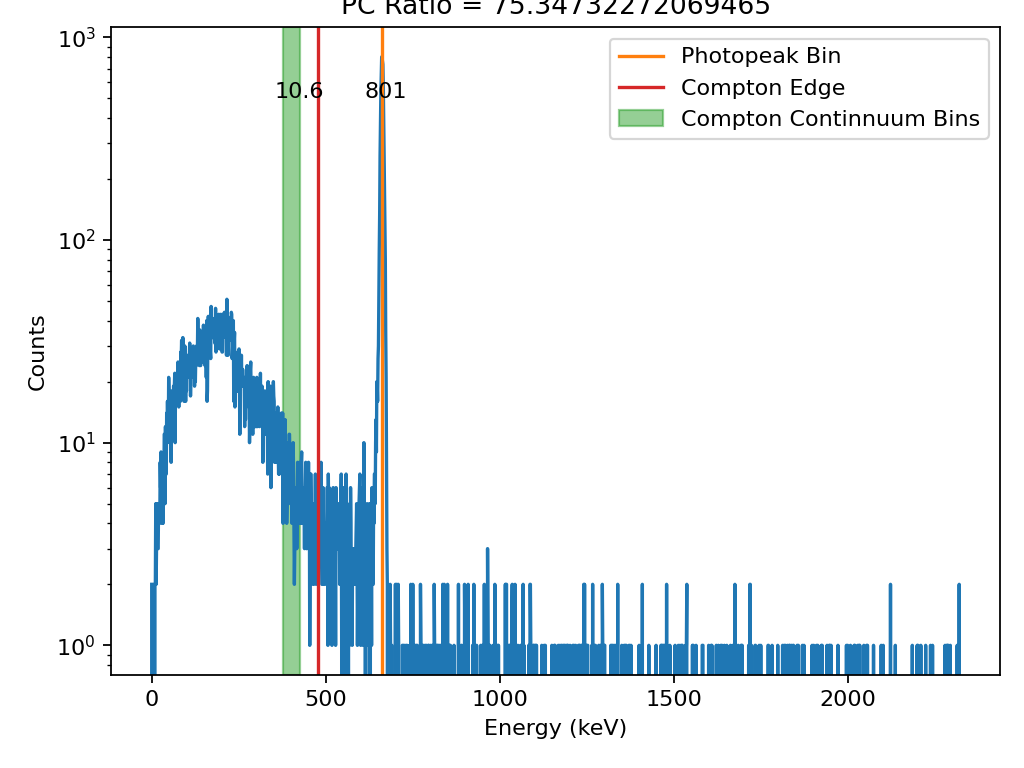

In [110]:
# highlight compton edges
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.axvline(spec.bin_energies[spec.peaks],c='tab:orange',label='Photopeak Bin')
plt.axvline(compton_edge,c='tab:red',label='Compton Edge')
plt.axvspan(spec.bin_energies[compton_edge_channels[0]-compton_edge_setback-compton_bin_width],spec.bin_energies[compton_edge_channels[0]-compton_edge_setback+compton_bin_width],color='tab:green',alpha=0.5,label='Compton Continnuum Bins')
plt.text(spec.bin_energies[spec.peaks]-50,500,photopeak_counts[0])
plt.text(spec.bin_energies[compton_edge_channels[0]-compton_edge_setback]-50,500,round(compton_counts,1))

plt.title('PC Ratio = '+str(pc_ratio))
plt.legend()
plt.show()

In [ ]:
compton_edge_setback = 10
spec.find_PC_ratio(compton_edge_setback=10)
spec.pc_ratio